***

*Course:* [Math 535](https://people.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS)  
*Chapter:* 2-Least squares   
*Author:* [Sebastien Roch](https://people.math.wisc.edu/~roch/), Department of Mathematics, University of Wisconsin-Madison  
*Updated:* Jan 4, 2024   
*Copyright:* &copy; 2024 Sebastien Roch

***

In [1]:
# IF RUNNING ON GOOGLE COLAB, UNCOMMENT THE FOLLOWING CODE CELL
# When prompted, upload: 
#     * mmids.py
#     * advertising.csv 
# from your local file system
# Files at: https://github.com/MMiDS-textbook/MMiDS-textbook.github.io/tree/main/utils
# Alternative instructions: https://colab.research.google.com/notebooks/io.ipynb

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [4]:
# PYTHON 3
import numpy as np
from numpy import linalg as LA
from numpy.random import default_rng
rng = default_rng(535)
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import mmids

## Motivating example: predicting sales

The following dataset is from [[ISLR]](http://faculty.marshall.usc.edu/gareth-james/ISL/). Quoting [ISLR, Section 2.1]:

> Suppose that we are statistical consultants hired by a client to provide advice on how to improve sales of a particular product. The `Advertising` data set consists of the `sales` of that product in 200 different markets, along with advertising budgets for the product in each of those markets for three different media: `TV`, `radio`, and `newspaper`. [...] It is not possible for our client to directly increase sales of the product. On the other hand, they can control the advertising expenditure in each of the three media. Therefore, if we determine that there is an association between advertising and sales, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales. In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

This a [regression](https://en.wikipedia.org/wiki/Regression_analysis) problem. That is, we want to estimate the relationship between an outcome variable and one or more predictors (or features). We load the data, show its first few lines and some statistics.

In [5]:
df = pd.read_csv('advertising.csv')

In [6]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [7]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


We will focus for now on the TV budget.

In [8]:
TV = df['TV'].to_numpy()
sales = df['sales'].to_numpy()

We make a scatterplot showing the realtion between those two quantities. 

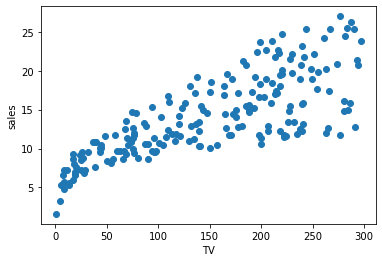

In [9]:
plt.scatter(TV, sales)
plt.xlabel('TV')
plt.ylabel('sales')
plt.show()

There does seem to be a relationship between the two. Roughly a higher TV budget is linked to higher sales, although the correspondence is not perfect. To express the relationship more quantitatively, we seek a function $f$ such that

$$
y \approx f(\mathbf{x})
$$

where $\mathbf{x}$ denotes a sample TV budget and $y$ is the corresponding observed sales. We might posit for instance that there exists a true $f$ and that each observation is disrupted by some noise $\varepsilon$

$$
y = f(\mathbf{x}) + \varepsilon.
$$

A natural way to estimate such an $f$ from data is [$k$-nearest-neighbors ($k$-NN) regression](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#k-NN_regression). Let the data be of the form $\{(\mathbf{x}_i, y_i)\}_{i=1}^n$, where in our case $\mathbf{x}_i$ is the TV budget of the $i$-th sample and $y_i$ is the corresponding sales. For each $\mathbf{x}$ (not necessarily in the data), we do the following:

- find the $k$ nearest $\mathbf{x}_i$'s to $\mathbf{x}$

- take an average of the corresponding $y_i$'s. 

We implement this method in Python. We use the function [`numpy.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) to sort an array and the function [`numpy.absolute`](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html) to compute the absolute deviation. Our quick implementation here assumes that the $\mathbf{x}_i$'s are scalars, i.e., one-dimensional vectors.

In [10]:
def knnregression(x,y,k,xnew):
    n = len(x)
    closest = np.argsort([np.absolute(x[i]-xnew) for i in range(n)])
    return np.mean(y[closest[0:k]])

For $k=3$ and a grid of $1000$ points, we get the following approximation $\hat{f}$. Here the function [`numpy.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) creates an array of equally spaced points.

In [11]:
k = 3
xgrid = np.linspace(TV.min(), TV.max(), num=1000)
yhat = [knnregression(TV,sales,k,xnew) for xnew in xgrid]

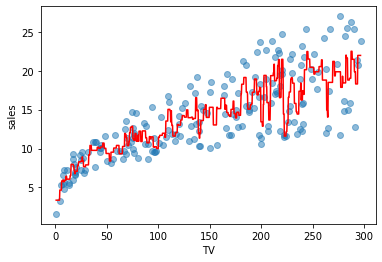

In [12]:
plt.scatter(TV, sales, alpha=0.5)
plt.xlabel('TV')
plt.ylabel('sales')
plt.plot(xgrid, yhat, 'r')
plt.show()

A higher $k$ gives something smoother.

In [13]:
k = 10
xgrid = np.linspace(TV.min(), TV.max(), num=1000)
yhat = [knnregression(TV,sales,k,xnew) for xnew in xgrid]

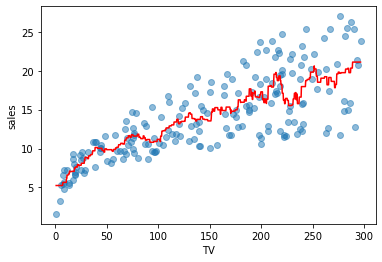

In [14]:
plt.scatter(TV, sales, alpha=0.5)
plt.xlabel('TV')
plt.ylabel('sales')
plt.plot(xgrid, yhat, 'r')
plt.show()

## Background: linear spaces

**NUMERICAL CORNER:** The plane $P$ made of all points $(x,y,z) \in \mathbb{R}^3$ that satisfy $z = x+y$ is a linear subspace. Indeed, $0 = 0 + 0$ so $(0,0,0) \in P$. And, for any $\mathbf{u}_1 = (x_1, y_1, z_1)$ and $\mathbf{u}_2 = (x_2, y_2, z_2)$ such that $z_1 = x_1 + y_1$ and $z_2 = x_2 + y_2$ and for any $\alpha \in \mathbb{R}$, we have

$$
\alpha z_1 + z_2 = \alpha (x_1 + y_1) + (x_2 + y_2) = (\alpha x_1 + x_2) + (\alpha y_1 + y_2).
$$

That is, $\alpha \mathbf{u}_1 + \mathbf{u}_2$ satisfies the condition defining $P$ and therefore is itself in $P$. Note also that $P$ passes through the origin.

In this example, the linear subspace $P$ can be described alternatively as the collection of every vector of the form $(x, y, x+y)$.

We use [`plot_surface`](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html#mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface) to plot it over a grid of points created using [`numpy.meshgrid`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html).

In [3]:
x = np.linspace(0,1,num=101)
y = np.linspace(0,1,num=101)
X, Y = np.meshgrid(x, y)

In [4]:
print(X)

[[0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 ...
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]]


In [5]:
print(Y)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.98 0.98 0.98 ... 0.98 0.98 0.98]
 [0.99 0.99 0.99 ... 0.99 0.99 0.99]
 [1.   1.   1.   ... 1.   1.   1.  ]]


In [6]:
Z = X + Y
print(Z)

[[0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.01 0.02 0.03 ... 0.99 1.   1.01]
 [0.02 0.03 0.04 ... 1.   1.01 1.02]
 ...
 [0.98 0.99 1.   ... 1.96 1.97 1.98]
 [0.99 1.   1.01 ... 1.97 1.98 1.99]
 [1.   1.01 1.02 ... 1.98 1.99 2.  ]]


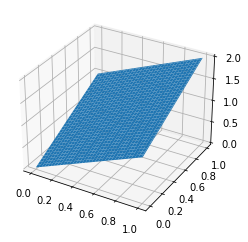

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

$\unlhd$

**NUMERICAL CORNER:** In Numpy, one can compute the rank of a matrix using the function [`numpy.linalg.matrix_rank`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html). We will see later in the course how to compute it using the singular value decomposition (which is how `LA.matrix_rank` does it).

Let's try the example above.

In [8]:
w1 = np.array([1., 0., 1.])
w2 = np.array([0., 1., 1.])
w3 = np.array([1., -1., 0.])
A = np.stack((w1, w2, w3), axis=-1)
print(A)

[[ 1.  0.  1.]
 [ 0.  1. -1.]
 [ 1.  1.  0.]]


We compute the rank of `A`.

In [9]:
LA.matrix_rank(A)

2

We take only the first two columns of `A` this time to form `B`.

In [10]:
B = np.stack((w1, w2),axis=-1)
print(B)

[[1. 0.]
 [0. 1.]
 [1. 1.]]


In [11]:
LA.matrix_rank(B)

2

In Numpy, `@` is used for matrix product.

In [12]:
C = np.array([[1., 0., 1.],[0., 1., -1.]])
print(C)

[[ 1.  0.  1.]
 [ 0.  1. -1.]]


In [13]:
LA.matrix_rank(C)

2

In [14]:
print(B @ C)

[[ 1.  0.  1.]
 [ 0.  1. -1.]
 [ 1.  1.  0.]]


$\unlhd$

## Overdetermined linear systems and regression analysis

**NUMERICAL CORNER:** To solve a linear system in Numpy, use [`numpy.linalg.solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html). As an example, we consider the overdetermined system with

$$
A = \begin{pmatrix}
1 & 0\\
0 & 1\\
1 & 1
\end{pmatrix}
\quad
\text{and}
\quad
\mathbf{b} = \begin{pmatrix}
0\\
0\\
2
\end{pmatrix}.
$$

We use [`numpy.ndarray.T`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html) for the transpose.

In [3]:
w1 = np.array([1., 0., 1.])
w2 = np.array([0., 1., 1.])
A = np.stack((w1, w2),axis=-1)
b = np.array([0., 0., 2.])
x = LA.solve(A.T @ A, A.T @ b)
print(x)

[0.66666667 0.66666667]


We can also use [`numpy.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) directly on the overdetermined system to compute the least-square solution.

In [4]:
x = LA.lstsq(A, b, rcond=None)[0]
print(x)

[0.66666667 0.66666667]


$\unlhd$

**NUMERICAL CORNER:** We implement back substitution in Python. In our naive implementation, we assume that the diagonal entries are not zero, which will suffice for our purposes. Here we use [`numpy.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) to compute inner products.

In [5]:
def backsubs(R,b):
    m = b.shape[0]
    x = np.zeros(m)
    for i in reversed(range(m)):
        x[i] = (b[i] - np.dot(R[i,i+1:m],x[i+1:m]))/R[i,i]
    return x

Forward substitution is implemented similarly.

In [6]:
def forwardsubs(L,b):
    m = b.shape[0]
    x = np.zeros(m)
    for i in range(m):
        x[i] = (b[i] - np.dot(L[i,0:i],x[0:i]))/L[i,i]
    return x

$\unlhd$

**NUMERICAL CORNER:** We implement the algorithm above. In our naive implementation, we assume that $B$ is positive definite, and therefore that all steps are well-defined.

In [7]:
def cholesky(B):
    n = B.shape[0] 
    L = np.zeros((n, n))
    for j in range(n):
        L[j,0:j] = forwardsubs(L[0:j,0:j],B[j,0:j])
        L[j,j] = np.sqrt(B[j,j] - LA.norm(L[j,0:j])**2)
    return L 

Here is a simple example.

In [8]:
B = np.array([[2., 1.],[1., 2.]])
print(B)

[[2. 1.]
 [1. 2.]]


In [9]:
L = cholesky(B)
print(L)

[[1.41421356 0.        ]
 [0.70710678 1.22474487]]


We can check that it produces the right factorization.

In [10]:
print(L @ L.T)

[[2. 1.]
 [1. 2.]]


$\unlhd$

**NUMERICAL CORNER:** We implement this algorithm below. In our naive implementation, we assume that $A$ has full column rank, and therefore that all steps are well-defined.

In [11]:
def ls_by_chol(A, b):
    L = cholesky(A.T @ A)
    z = forwardsubs(L, A.T @ b)
    return backsubs(L.T, z)

$\unlhd$

**NUMERICAL CORNER:** We test our least-squares method on simulated data. This has the advantage that we know the truth.

Suppose the truth is a linear function of one variable.

In [12]:
n, b0, b1 = 100, -1, 1
x = np.linspace(0,10,num=n)
y = b0 + b1*x

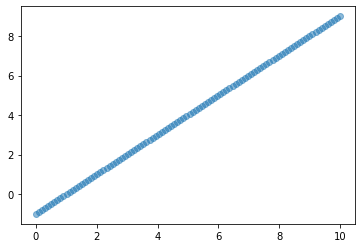

In [13]:
plt.scatter(x,y,alpha=0.5)
plt.show()

A perfect straight line is little too easy. So let's add some noise. That is, to each $y_i$ we add an independent random variable $\varepsilon_i$ with a standard Normal distribution (mean $0$, variance $1$).

In [14]:
y += rng.normal(0,1,n)

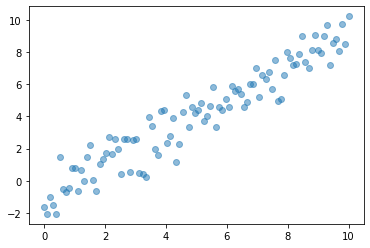

In [15]:
plt.scatter(x,y,alpha=0.5)
plt.show()

We form the matrix $A$ and use our least-squares code to solve for $\boldsymbol{\hat\beta}$. 

In [16]:
A = np.stack((np.ones(n),x),axis=-1)
coeff = ls_by_chol(A,y)
print(coeff)

[-1.03381171  1.01808039]


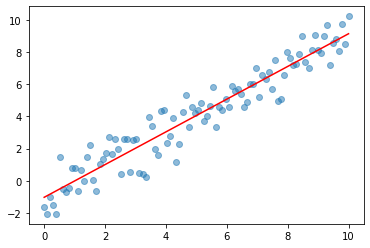

In [17]:
plt.scatter(x,y,alpha=0.5)
plt.plot(x,coeff[0]+coeff[1]*x,'r')
plt.show()

$\unlhd$

**NUMERICAL CORNER:** Suppose the truth is in fact a degree-two polynomial of one variable with Gaussian noise.

In [18]:
n, b0, b1, b2 = 100, 0, 0, 1
x = np.linspace(0,10,num=n)
y = b0 + b1 * x + b2 * x**2 + 10*rng.normal(0,1,n)

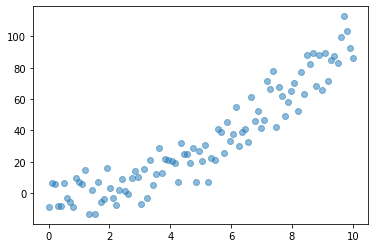

In [19]:
plt.scatter(x,y,alpha=0.5)
plt.show()

We form the matrix $A$ and use our least-squares code to solve for $\boldsymbol{\hat\beta}$. 

In [20]:
A = np.stack((np.ones(n), x, x**2), axis=-1)
coeff = ls_by_chol(A,y)
print(coeff)

[-2.76266982  1.01627798  0.93554204]


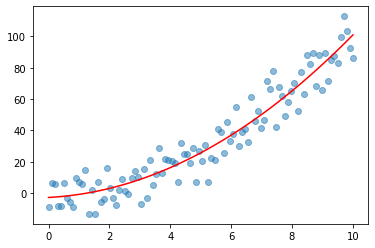

In [21]:
plt.scatter(x,y,alpha=0.5)
plt.plot(x, coeff[0] + coeff[1] * x + coeff[2] * x**2, 'r')
plt.show()

$\unlhd$

## QR decomposition and Householder transformations

**NUMERICAL CORNER:** We implement the Gram-Schmidt algorithm in Python. For reasons that will become clear in a future section, we output both the $\mathbf{q}_j$'s and $r_{ij}$'s, each in matrix form.

In [3]:
def gramschmidt(A):
    (n,m) = A.shape
    Q = np.zeros((n,m))
    R = np.zeros((m,m))
    for j in range(m):
        v = np.copy(A[:,j])
        for i in range(j):
            R[i,j] = np.dot(Q[:,i], A[:,j])
            v -= R[i,j]*Q[:,i]
        R[j,j] = LA.norm(v)
        Q[:,j] = v/R[j,j]
    return Q, R

Let's try a simple example.

In [4]:
w1 = np.array([1., 0., 1.])
w2 = np.array([0., 1., 1.])
A = np.stack((w1, w2),axis=-1)
print(A)

[[1. 0.]
 [0. 1.]
 [1. 1.]]


In [5]:
Q, R = gramschmidt(A)

In [6]:
print(Q)

[[ 0.70710678 -0.40824829]
 [ 0.          0.81649658]
 [ 0.70710678  0.40824829]]


In [7]:
print(R)

[[1.41421356 0.70710678]
 [0.         1.22474487]]


$\unlhd$

**NUMERICAL CORNER:** We implement the QR approach to least squares and return to our previous linear regression example.

In [8]:
def ls_by_qr(A, b):
    Q, R = gramschmidt(A)
    return mmids.backsubs(R, Q.T @ b)

In [9]:
n, b0, b1 = 100, -1, 1
x = np.linspace(0,10,num=n)
y = b0 + b1*x + rng.normal(0,1,n)
A = np.stack((np.ones(n),x),axis=-1)
coeff = ls_by_qr(A,y)
print(coeff)

[-1.03381171  1.01808039]


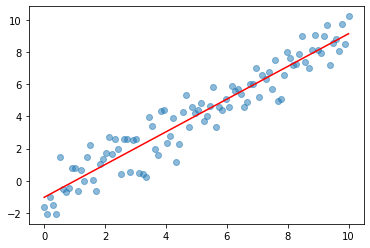

In [10]:
plt.scatter(x,y,alpha=0.5)
plt.plot(x,coeff[0]+coeff[1]*x,'r')
plt.show()

$\unlhd$

**NUMERICAL CORNER:** We implement the procedure above in Python. We will need the following function. For $\alpha \in \mathbb{R}$, let the sign of $\alpha$ be

$$
\mathrm{sign}(\alpha)
= 
\begin{cases}
1 & \text{if $\alpha > 0$}\\
0 & \text{if $\alpha = 0$}\\
-1 & \text{if $\alpha < 0$}
\end{cases}
$$

For example, in Python, using the function [`numpy.sign`](https://numpy.org/doc/stable/reference/generated/numpy.sign.html):

In [11]:
np.sign(-10), np.sign(20), np.sign(0)

(-1, 1, 0)

The following function constructs the upper triangular matrix $R$ by iteratively modifying the relevant block of $A$. On the other hand, computing the matrix $Q$ actually requires extra computational work that is often not needed. We saw that, in the context of the least-squares problem, we really only need to compute $Q^T \mathbf{b}$ for some input vector $\mathbf{b}$. This can be done at the same time that $R$ is constructed, as follows. The key point to note is that $Q^T \mathbf{b} = H_m \cdots H_1 \mathbf{b}$.

See [here](https://numpy.org/doc/stable/reference/generated/numpy.copy.html) for an explanation of `numpy.copy`.

In [12]:
def householder(A, b):
    n, m = A.shape
    R = np.copy(A)
    Qtb = np.copy(b)
    for k in range(m):
    
        # computing z
        y = R[k:n,k]
        e1 = np.zeros(n-k)
        e1[0] = 1
        z = np.sign(y[0]) * LA.norm(y) * e1 + y
        z = z / LA.norm(z)
        
        # updating R
        R[k:n,k:m] = R[k:n,k:m] - 2 * np.outer(z, z) @ R[k:n,k:m]
        
        # updating Qtb
        Qtb[k:n] = Qtb[k:n] - 2 * np.outer(z, z) @ Qtb[k:n]
    
    return R[0:m,0:m], Qtb[0:m]

In `householder`, we use both reflections defined above. We will not prove this here, but the particular choice made has good numerical properties. Quoting [TB, Lecture 10]:

> Mathematically, either choice of sign is satisfactory. However, this is a case where numerical stability -- insensitivity to rounding errors -- dictates that one choice should be taken rather than the other. For numerical stability, it is desirable to reflect $\mathbf{x}$ to the vector $z \|\mathbf{x}\| \mathbf{e}_1$ that is not too close to $\mathbf{x}$ itself. [...] Suppose that [in the figure above] the angle between $H^+$ and the $\mathbf{e}_1$ axis is very small. Then the vector $\mathbf{v} = \|\mathbf{x}\| \mathbf{e}_1 - \mathbf{x}$ is much smaller than $\mathbf{x}$ or $\|\mathbf{x}\| \mathbf{e}_1$. Thus the calculation of $\mathbf{v}$ represents a subtraction of nearby quantities and will tend to suffer from cancellation errors. 

We return to our regression example.

In [13]:
n, b0, b1, b2 = 100, 0, 0, 1
x = np.linspace(0,10,num=n)
y = b0 + b1*x + b2 * x**2 + 10*rng.normal(0,1,n)
A = np.stack((np.ones(n), x, x**2), axis=-1)
R, Qtb = householder(A, y)
coeff = mmids.backsubs(R, Qtb)
print(coeff)

[-2.76266982  1.01627798  0.93554204]


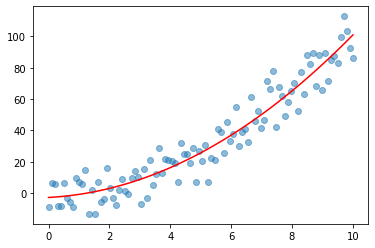

In [14]:
plt.scatter(x,y,alpha=0.5)
plt.plot(x, coeff[0] + coeff[1]*x + coeff[2] * x**2, 'r')
plt.show()

One advantage of the Householder approach is that it produces a matrix $Q$ with very good orthogonality, i.e., $Q^T Q \approx I$. We give a quick example below comparing Gram-Schmidt and Householder. (The choice of matrix $A$ will become clearer when we discuss the singular value decomposition later in the chapter.)

In [15]:
n = 50
U, W = LA.qr(rng.normal(0,1,(n,n)))
V, W = LA.qr(rng.normal(0,1,(n,n)))
S = np.diag((1/2) ** np.arange(1,n+1))
A = U @ S @ V.T

In [16]:
Qgs, Rgs = gramschmidt(A)
print(LA.norm(A - Qgs @ Rgs))

1.2959101704482747e-16


In [17]:
print(LA.norm(Qgs.T @ Qgs - np.identity(n)))

23.902062528929683


As you can see above, the $Q$ and $R$ factors produced by Gram-Schmidt do have the property that $QR \approx A$. However, $Q$ is far from orthogonal. (Recall that `LA.norm` computes the Frobenius norm introduced previously.)

On the other hand, Householder reflections perform much better in that respect as we show next. Here we use the implementation of Householder transformations in [`numpy.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html).

In [18]:
Qhh, Rhh = LA.qr(A)
print(LA.norm(A - Qhh @ Rhh))

2.9017844488725664e-16


In [19]:
print(LA.norm(Qhh.T @ Qhh - np.identity(n)))

4.934757529567654e-15


$\unlhd$